In [59]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

import string

<h1>DATA COLLECTION</h1>

In [60]:
# connect to the database file
db_con = sqlite3.connect(r'/Users/jmc/GitHub/predict-pwd-strenght-npl/database/password_data.sqlite')

In [61]:
df = pd.read_sql_query('SELECT * FROM Users', db_con)

<h1>DATA CLEANING</h1>

In [62]:
df.head(2)

,index,password,strength
0,0,zxe870819,1
1,1,xw46454nr23l,1


In [63]:
df.drop(['index'], axis=1, inplace=True)

In [64]:
# check for duplicates
df.duplicated().sum()

0

In [65]:
# check for missing values
df.isnull().sum()

password    0
strength    0
dtype: int64

In [66]:
# check the types of the features
df.dtypes

password    object
strength     int64
dtype: object

In [67]:
# check if there's any row with negative strenght
df['strength'].unique()

array([1, 2, 0])

<h1>DATA ANALYSIS</h1>

Semantic analysis

In [68]:
# how many passwords only have numeric characters?
df['password'].str.isnumeric().sum()

26

In [69]:
# how many passwords only have Upper-case characters?
df['password'].str.isupper().sum()

1506

In [70]:
# how many passwords have alpha characters?
df['password'].str.isalpha().sum()

50

In [71]:
# how many passwords have alphanumeric characters?
df['password'].str.isalnum().sum()

97203

In [72]:
# how many passwords have title-case characters?
df['password'].str.istitle().sum()

932

In [73]:
# how many passwords have special characters?
def get_special_char_pwd(row):
    for char in row:
        if char in string.punctuation:
            return 1
        else:
            pass

In [74]:
df[df['password'].apply(get_special_char_pwd)==1].shape

(2663, 2)

<h1>FEATURE ENGINEERING</h1>

What are the factors that can impact the strenght of a password? those factors are going to be our features to train our ml model
Factors I'll be using:
- length
- lower frequency
- upper frequency
- digit frequency
- special character frequency

In [75]:
# length
df['length'] = df['password'].str.len()

In [76]:
# lower frequency
def get_lower_freq(row):
    return len([char for char in row if char.islower()])/len(row)

df['lower_freq'] = np.round(df['password'].apply(get_lower_freq),3)

In [77]:
# upper frequency
def get_upper_freq(row):
    return len([char for char in row if char.isupper()])/len(row)

df['upper_freq'] = np.round(df['password'].apply(get_upper_freq),3)

In [78]:
# lower frequency
def get_digit_freq(row):
    return len([char for char in row if char.isdigit()])/len(row)

df['digit_freq'] = np.round(df['password'].apply(get_digit_freq),3)

In [79]:
# special character frequency
def get_special_char_freq(row):
    return len([char for char in row if char in string.punctuation])/len(row)

df['special_char_freq'] = np.round(df['password'].apply(get_special_char_freq),3)

<h1>DATA ANALYSIS ON FEATURES CREATED</h1>

Descriptive Statistics on new features

In [107]:
new_features = ['length', 'lower_freq', 'upper_freq',
       'digit_freq', 'special_char_freq']

In [112]:
for col in new_features:
    print(f'{col} Analysis:')
    print(df.groupby('strength')[col].describe())
    print('\n')

length Analysis:
            count       mean       std   min   25%   50%   75%    max
strength                                                             
0         13622.0   6.550947  0.509951   1.0   6.0   7.0   7.0    7.0
1         73883.0   9.611074  1.338700   8.0   9.0   9.0  10.0   13.0
2         12495.0  15.953421  2.560660  14.0  15.0  16.0  16.0  220.0


lower_freq Analysis:
            count      mean       std  min    25%    50%    75%    max
strength                                                              
0         13622.0  0.708050  0.181488  0.0  0.667  0.714  0.857  1.000
1         73883.0  0.630067  0.217204  0.0  0.556  0.667  0.778  0.923
2         12495.0  0.424679  0.166605  0.0  0.312  0.400  0.500  0.917


upper_freq Analysis:
            count      mean       std  min   25%    50%  75%    max
strength                                                           
0         13622.0  0.012872  0.094251  0.0  0.00  0.000  0.0  1.000
1         73883.0  0.007915 

<Axes: xlabel='strength', ylabel='special_char_freq'>

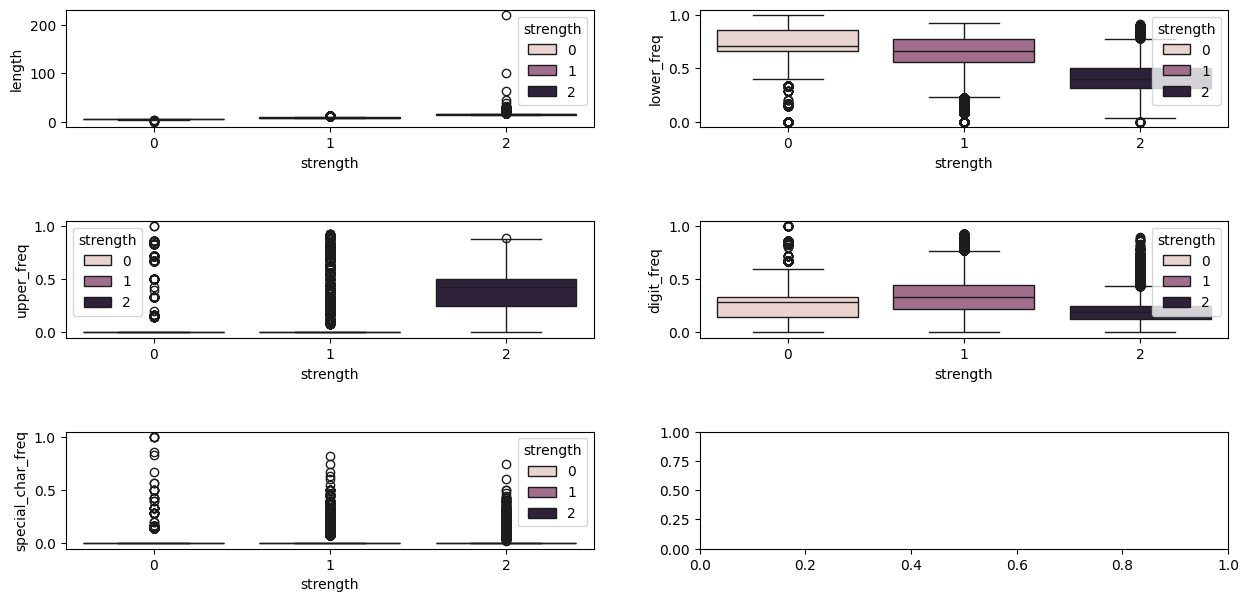

In [114]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(15,7))
plt.subplots_adjust(hspace=0.8)

sns.boxplot(x='strength',y='length', hue='strength', ax=ax1, data=df)
sns.boxplot(x='strength',y='lower_freq', hue='strength', ax=ax2, data=df)
sns.boxplot(x='strength',y='upper_freq', hue='strength', ax=ax3, data=df)
sns.boxplot(x='strength',y='digit_freq', hue='strength', ax=ax4, data=df)
sns.boxplot(x='strength',y='special_char_freq', hue='strength', ax=ax5, data=df)